In [52]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [53]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\v2_gold_annotation"

In [54]:
MOTION = "HIT"

In [55]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

16


<Axes: xlabel='motion_type', ylabel='count'>

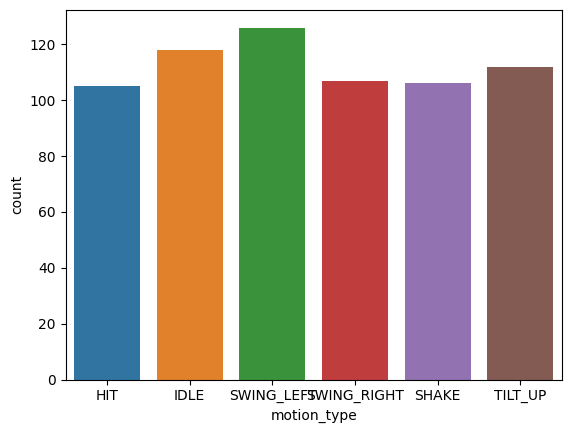

In [56]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [57]:
len(df)

674

In [58]:
df.drop(columns=df.filter(regex=r'^ahrs').columns, inplace=True)

In [59]:
# Keeps values equal to 'X', changes everything else to 'Y'
df['motion_type'] = df['motion_type'].where(df['motion_type'] == f'{MOTION}', f'NOT_{MOTION}')

In [60]:
df.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,mag_x_0,mag_y_0,mag_z_0,gyro_x_1,...,gyro_x_29,gyro_y_29,gyro_z_29,accel_x_29,accel_y_29,accel_z_29,mag_x_29,mag_y_29,mag_z_29,motion_type
0,-5.048313,0.544225,2.133175,4.55400,8.42100,-4.45695,24.187502,3.93750,-16.462502,-4.849900,...,6.140613,4.273912,-5.951687,7.384950,-4.68300,-1.177950,39.525002,-7.237500,-12.993751,HIT
1,0.511087,-0.001787,0.113850,7.98405,3.99495,-2.43300,49.050003,-3.86250,-7.481250,0.511087,...,5.875513,6.787962,-5.628287,8.638050,-4.89405,-6.553051,42.525002,-9.037500,-8.325001,HIT
2,0.689975,-0.069025,-0.549450,5.70405,7.45095,-2.50305,49.575001,0.86250,-6.918750,0.689975,...,3.287075,4.430663,-5.384225,7.177050,-5.79900,-4.045050,39.618752,-8.756250,-7.425000,HIT
3,-2.874850,-0.293012,-0.687638,5.19105,8.42805,-3.96105,41.568752,-11.28750,-12.468751,-2.874850,...,3.713600,1.932150,-4.427638,8.508000,-0.89205,-2.488050,39.075001,-9.862500,-11.943750,HIT
4,0.170775,0.027500,-0.111787,7.15005,3.16905,-0.74505,47.268753,-4.96875,-9.506250,0.170775,...,-10.236600,12.141250,2.020150,7.918951,-1.33005,-2.650950,39.000000,-9.431251,-11.400001,HIT


<Axes: xlabel='motion_type', ylabel='count'>

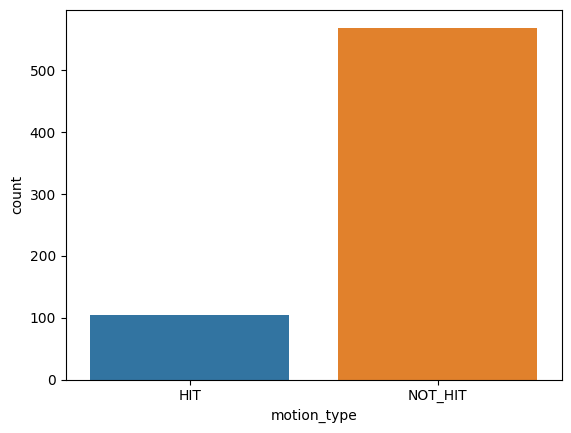

In [61]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [62]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [63]:
n_timesteps = 30
channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z"]
n_channels = len(channels)

X = np.zeros((len(df), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X[:, c, t] = X_df[col_name].values

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

In [68]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
clf_minirocket = make_pipeline(
    MiniRocketMultivariate(random_state=42),
    StandardScaler(with_mean=False),
    RidgeClassifier(alpha=1.0)
)

In [ ]:
# clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)

In [71]:
clf_minirocket.fit(X_train, y_train)

,steps,"[('minirocketmultivariate', ...), ('standardscaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf_minirocket.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

1.0
1.0
1.0
1.0


In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [74]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [75]:
scores_accuracy = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=f1_macro
)

In [76]:
print("Cross-validated Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("Cross-validated Precision:", scores_precision.mean(), "±", scores_precision.std())
print("Cross-validated Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("Cross-validated F1-score :", scores_f1.mean(), "±", scores_f1.std())

Cross-validated Accuracy : 1.0 ± 0.0
Cross-validated Precision: 1.0 ± 0.0
Cross-validated Recall   : 1.0 ± 0.0
Cross-validated F1-score : 1.0 ± 0.0


In [77]:
from joblib import dump

In [78]:
dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [79]:
dump(clf_minirocket, "minirocket_hit_nohit.joblib")

['minirocket_hit_nohit.joblib']